In [1]:
import numpy as np
import matplotlib.pylab as plt
from math import *
#from sklearn.models import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn import svm
import pandas as pd
import seaborn as sns
from pylab import rcParams
from matplotlib import rc
from mpl_toolkits.mplot3d import Axes3D
import time
%matplotlib notebook

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
RANDOM_SEED = 42
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ['#01BEFE', '#FFDD00', '#FF7D00', '#FF006D', '#ADFF02', '#8F00FF']
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from sklearn.metrics import mean_squared_error as mse

In [5]:
df = pd.read_csv('inputs/DS1_1440.csv')

In [6]:
df.shape

(1440, 2)

In [7]:
import torch
import gc
import torch.nn as nn
from tqdm import tqdm_notebook as tqdm
from torch.utils.data import Dataset, DataLoader

In [8]:
class WindDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        item = self.x[idx]
        label = self.y[idx]
        
        return item, label

In [9]:
class CNNFORECAST(nn.Module):
    def __init__(self):
        super(CNNFORECAST,self).__init__()
        self.conv1d = nn.Conv1d(5, 128, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64,1)
        
    def forward(self,x):
        x = self.conv1d(x)
        x = self.relu(x)
        x = x.view(-1) # batch_size * 64
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        
        return x

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNNFORECAST().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.MSELoss()

In [11]:
from processing import create_features, split_data

In [12]:
train_len = int(.6*df.shape[0])
train_data, val_data, test_data = split_data(df.wind_speed.values, train_len)
train_data = np.float32(train_data)
val_data = np.float32(val_data)
test_data = np.float32(test_data)

In [13]:
window_size = 5

In [14]:
xtrain, ytrain = create_features(train_data, window_size)
xval, yval = create_features(val_data, window_size)
xtest, ytest = create_features(test_data, window_size)

In [15]:
ytest.shape

(283,)

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNNFORECAST().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.MSELoss()

In [17]:
train = WindDataset(xtrain.reshape(xtrain.shape[0], xtrain.shape[1], 1), ytrain)
valid = WindDataset(xval.reshape(xval.shape[0], xval.shape[1], 1), yval)
test = WindDataset(xtest.reshape(xtest.shape[0], xtest.shape[1], 1), ytest)
train_loader = torch.utils.data.DataLoader(train, batch_size=1, shuffle=False)
valid_loader = torch.utils.data.DataLoader(train, batch_size=1, shuffle=False)
test_loader = torch.utils.data.DataLoader(test, batch_size=1, shuffle=False)

In [18]:
train_losses = []
valid_losses = []
def Train():
    
    running_loss = .0
    
    model.train()
    
    for idx, (inputs,labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(inputs)
        loss = criterion(preds,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss
        
    train_loss = running_loss/len(train_loader)
    train_losses.append(train_loss.detach().numpy())
    
    print(f'train_loss {train_loss}')
    
def Valid():
    running_loss = .0
    
    model.eval()
    
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            preds = model(inputs)
            loss = criterion(preds,labels)
            running_loss += loss
            
        valid_loss = running_loss/len(valid_loader)
        valid_losses.append(valid_loss.detach().numpy())
        print(f'valid_loss {valid_loss}')

In [19]:
epochs = 200
for epoch in range(epochs):
    print('epochs {}/{}'.format(epoch+1,epochs))
    Train()
    Valid()
    gc.collect()

epochs 1/200
train_loss 46.90507125854492
valid_loss 22.49884796142578
epochs 2/200
train_loss 10.071846961975098
valid_loss 2.690556526184082
epochs 3/200
train_loss 1.674973964691162
valid_loss 1.350630283355713
epochs 4/200
train_loss 1.321889877319336
valid_loss 1.2700867652893066
epochs 5/200
train_loss 1.2496312856674194
valid_loss 1.2048900127410889
epochs 6/200
train_loss 1.1885038614273071
valid_loss 1.1447356939315796
epochs 7/200
train_loss 1.130136489868164
valid_loss 1.0870662927627563
epochs 8/200
train_loss 1.0739316940307617
valid_loss 1.032103180885315
epochs 9/200
train_loss 1.0154893398284912
valid_loss 0.9750396609306335
epochs 10/200
train_loss 0.964494526386261
valid_loss 0.9291200041770935
epochs 11/200
train_loss 0.9208738803863525
valid_loss 0.8889833688735962
epochs 12/200
train_loss 0.8823650479316711
valid_loss 0.8534800410270691
epochs 13/200
train_loss 0.8483635783195496
valid_loss 0.8221602439880371
epochs 14/200
train_loss 0.8181023597717285
valid_loss 0

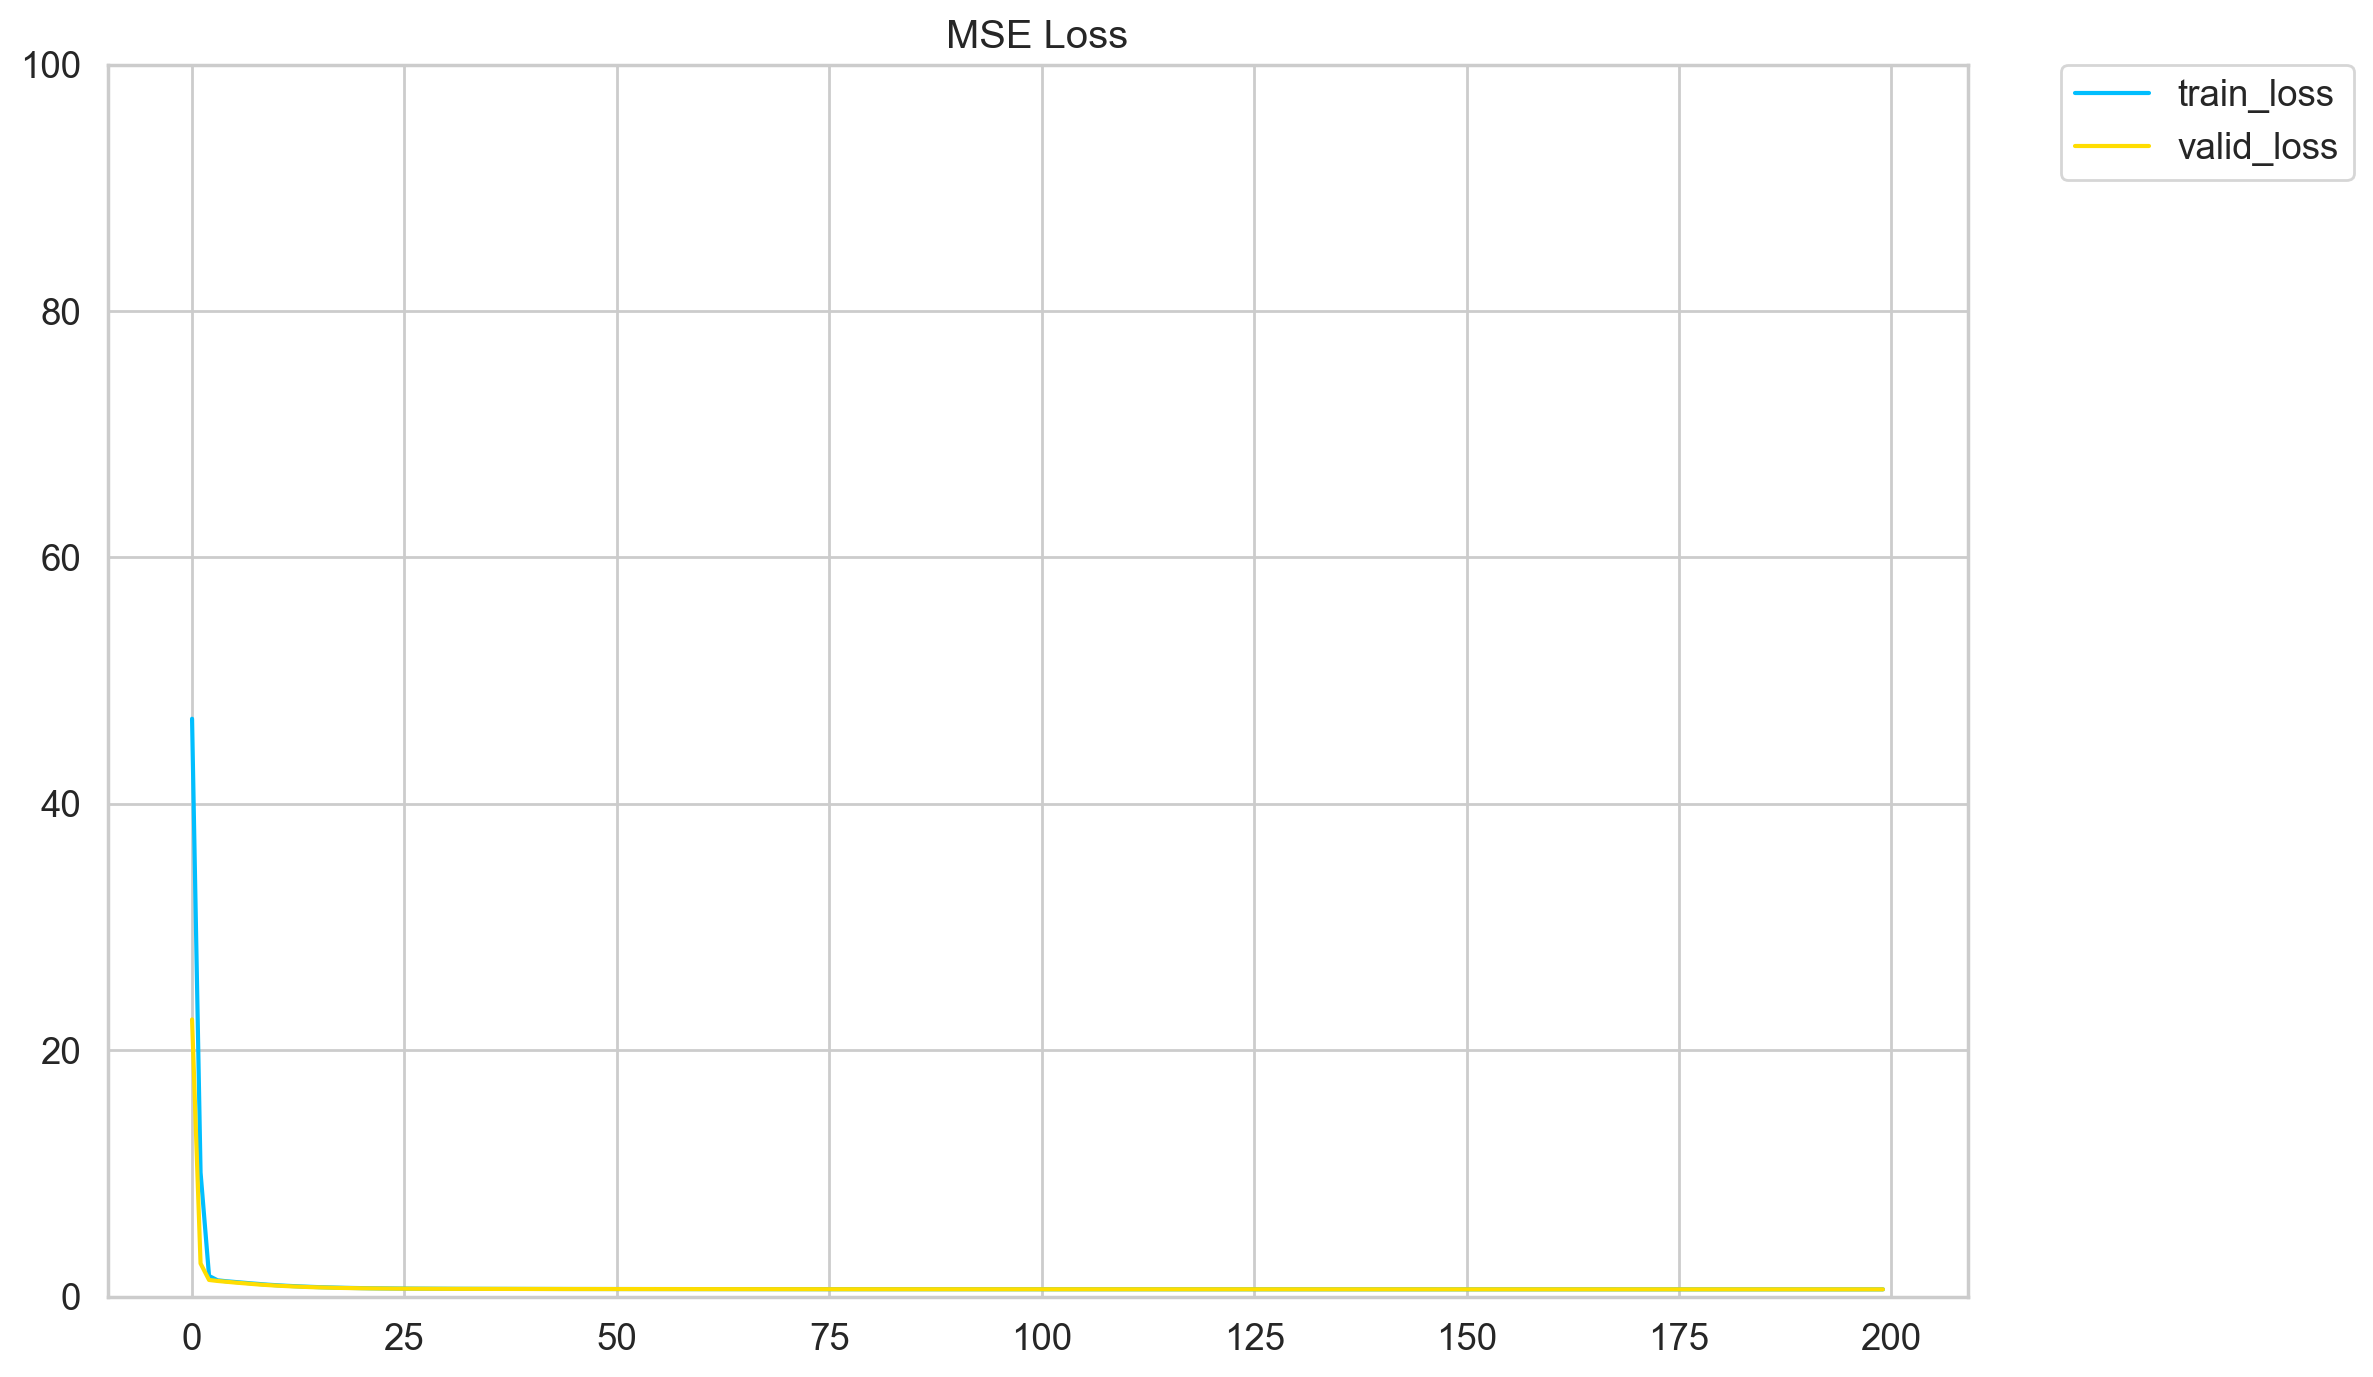

In [20]:
import matplotlib.pyplot as plt
plt.plot(train_losses,label='train_loss')
plt.plot(valid_losses,label='valid_loss')
plt.title('MSE Loss')
plt.ylim(0, 100)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

In [21]:
inputs = xtest.reshape(xtest.shape[0], xtest.shape[1], 1)

In [22]:
torch.save(model, 'models/cnn_model.pth.tar')

In [23]:
predictions = []
test_losses = []
running_loss = 0.
model.eval()
with torch.no_grad():
    for idx, (inputs, labels) in enumerate(test_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        for input in inputs:
            preds = model.forward(input)
            # print(preds)
            print()
            predictions.append(preds.item())
            loss = criterion(preds,labels)
            running_loss += loss
        
    test_loss = running_loss/len(valid_loader)
    test_losses.append(test_loss.detach().numpy())

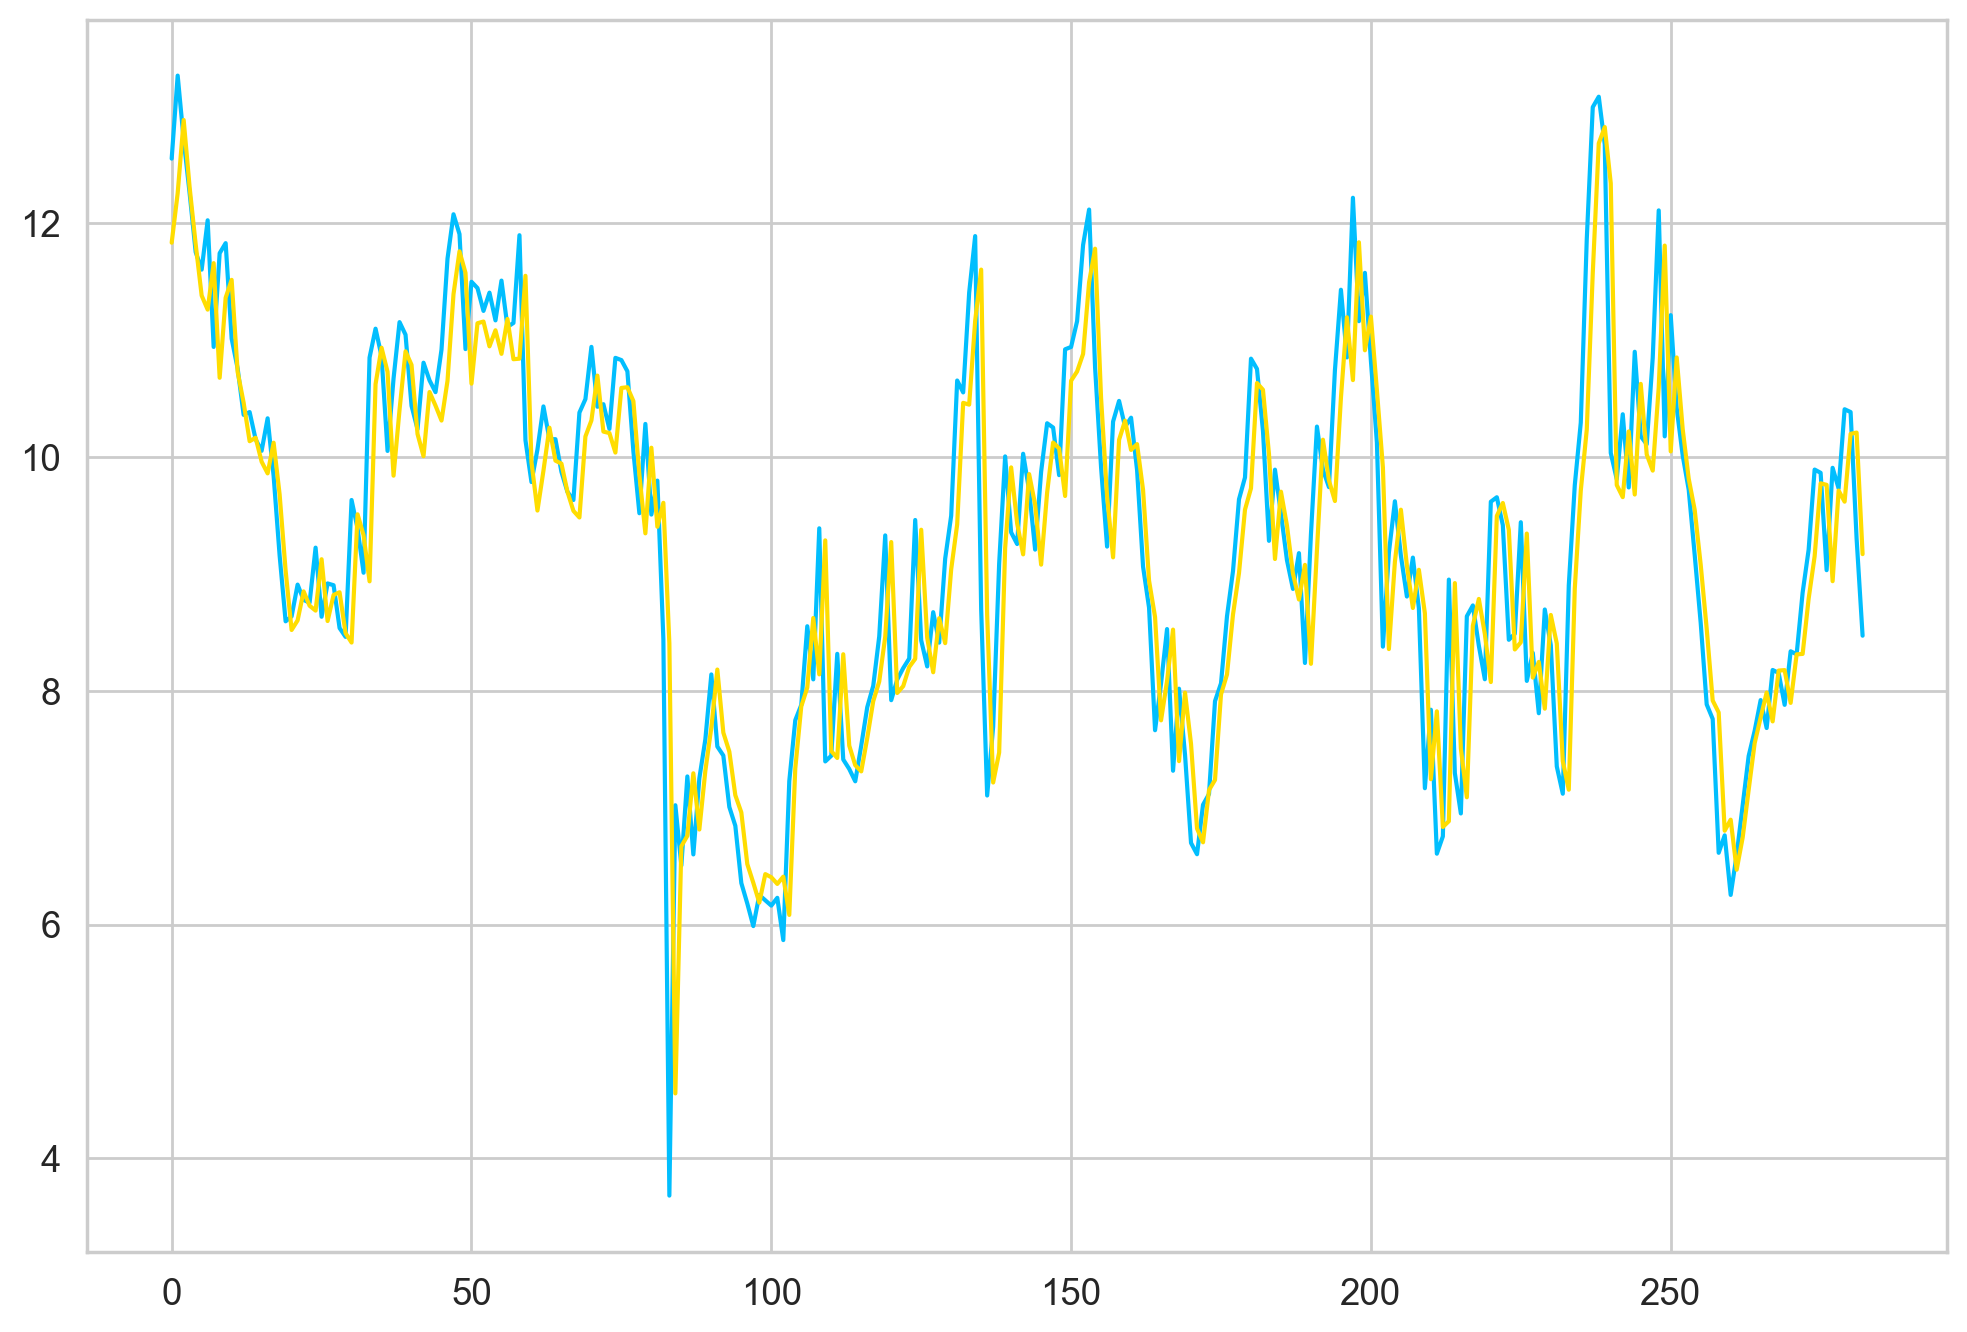

In [24]:
plt.plot(ytest)
plt.plot(predictions)

In [25]:
len(predictions) == len(ytest)

True

In [26]:
mse(predictions, ytest)

0.6202459039822092

In [27]:
import pickle

In [28]:
file = open('pred_cnn_1', 'ab')
pickle.dump(predictions, file)
file.close()

## May-Dataset

In [282]:
df = pd.read_csv('inputs/DS2_1448.csv')

In [283]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNNFORECAST().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.MSELoss()

In [284]:
from processing import create_features, split_data

In [285]:
train_len = int(.6*df.shape[0])
train_data, val_data, test_data = split_data(df.wind_speed.values, train_len)
train_data = np.float32(train_data)
val_data = np.float32(val_data)
test_data = np.float32(test_data)

In [286]:
window_size = 5

In [287]:
xtrain, ytrain = create_features(train_data, window_size)
xval, yval = create_features(val_data, window_size)
xtest, ytest = create_features(test_data, window_size)

In [288]:
ytest.shape

(293,)

In [290]:
train = WindDataset(xtrain.reshape(xtrain.shape[0], xtrain.shape[1], 1), ytrain)
valid = WindDataset(xval.reshape(xval.shape[0], xval.shape[1], 1), yval)
test = WindDataset(xtest.reshape(xtest.shape[0], xtest.shape[1], 1), ytest)
train_loader = torch.utils.data.DataLoader(train, batch_size=1, shuffle=False)
valid_loader = torch.utils.data.DataLoader(train, batch_size=1, shuffle=False)
test_loader = torch.utils.data.DataLoader(test, batch_size=1, shuffle=False)

In [291]:
train_losses = []
valid_losses = []
def Train():
    
    running_loss = .0
    
    model.train()
    
    for idx, (inputs,labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(inputs)
        loss = criterion(preds,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss
        
    train_loss = running_loss/len(train_loader)
    train_losses.append(train_loss.detach().numpy())
    
    print(f'train_loss {train_loss}')
    
def Valid():
    running_loss = .0
    
    model.eval()
    
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            preds = model(inputs)
            loss = criterion(preds,labels)
            running_loss += loss
            
        valid_loss = running_loss/len(valid_loader)
        valid_losses.append(valid_loss.detach().numpy())
        print(f'valid_loss {valid_loss}')

In [292]:
epochs = 200
for epoch in range(epochs):
    print('epochs {}/{}'.format(epoch+1,epochs))
    Train()
    Valid()
    gc.collect()

epochs 1/200
train_loss 26.712604522705078
valid_loss 12.522245407104492
epochs 2/200
train_loss 6.3063063621521
valid_loss 2.3820528984069824
epochs 3/200
train_loss 1.7187031507492065
valid_loss 1.46965491771698
epochs 4/200
train_loss 1.4543899297714233
valid_loss 1.4225908517837524
epochs 5/200
train_loss 1.4125773906707764
valid_loss 1.3851255178451538
epochs 6/200
train_loss 1.377643346786499
valid_loss 1.3518224954605103
epochs 7/200
train_loss 1.3456159830093384
valid_loss 1.3208290338516235
epochs 8/200
train_loss 1.3158341646194458
valid_loss 1.2925713062286377
epochs 9/200
train_loss 1.2885465621948242
valid_loss 1.266952633857727
epochs 10/200
train_loss 1.2639880180358887
valid_loss 1.2441898584365845
epochs 11/200
train_loss 1.241755485534668
valid_loss 1.2234050035476685
epochs 12/200
train_loss 1.221490740776062
valid_loss 1.2044026851654053
epochs 13/200
train_loss 1.2029519081115723
valid_loss 1.1872085332870483
epochs 14/200
train_loss 1.1861966848373413
valid_loss 1

In [ ]:
inputs = xtest.reshape(xtest.shape[0], xtest.shape[1], 1)

In [293]:
torch.save(model, 'models/cnn_model_2.pth.tar')

In [294]:
predictions = []
test_losses = []
running_loss = 0.
model.eval()
with torch.no_grad():
    for idx, (inputs, labels) in enumerate(test_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        for input in inputs:
            preds = model.forward(input)
            # print(preds)
            print()
            predictions.append(preds.item())
            loss = criterion(preds,labels)
            running_loss += loss
        
    test_loss = running_loss/len(valid_loader)
    test_losses.append(test_loss.detach().numpy())

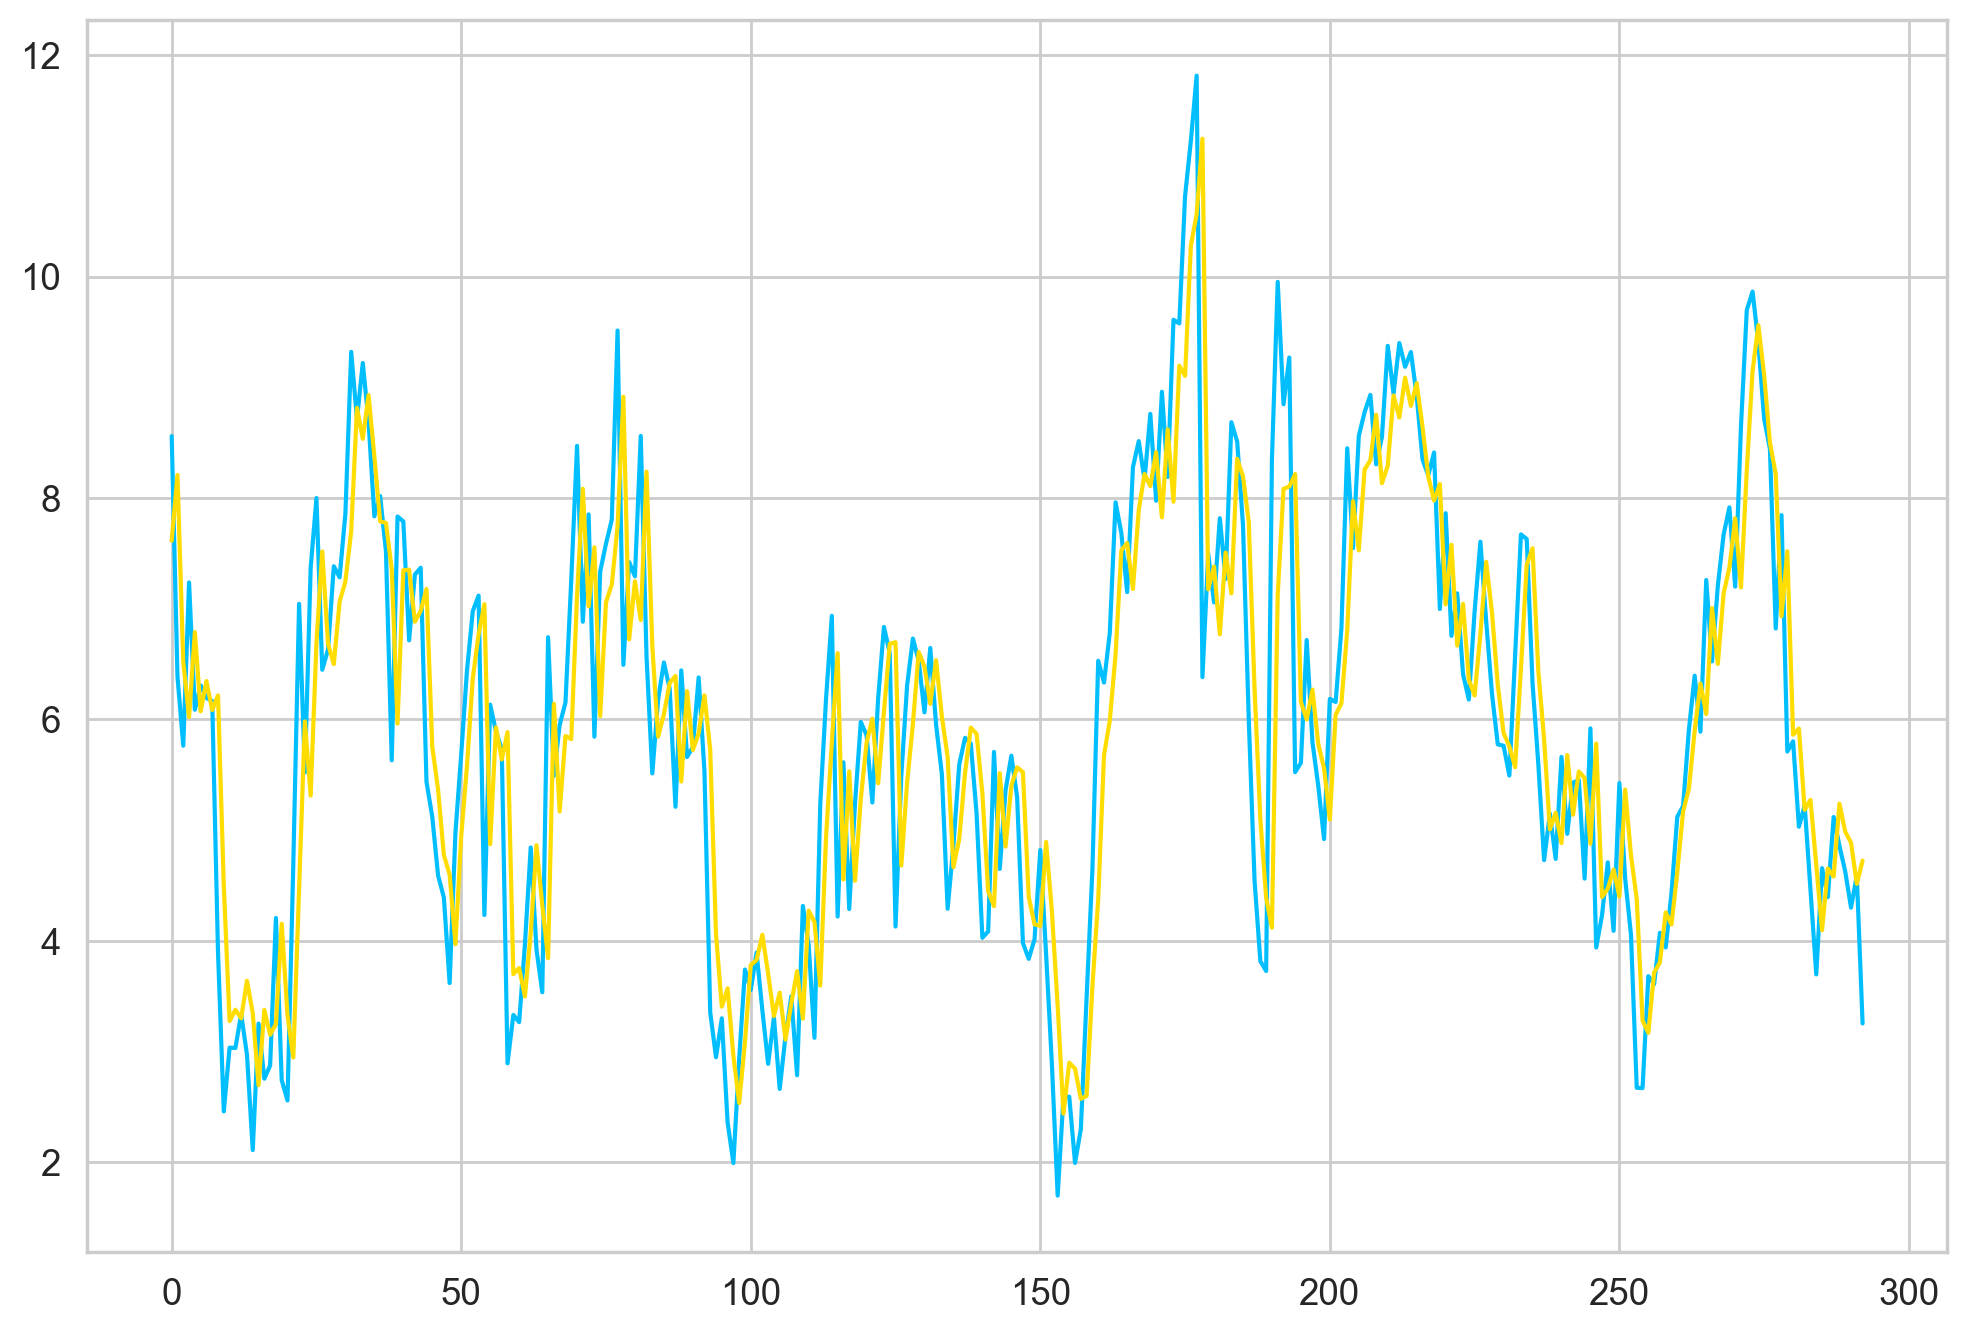

In [295]:
plt.plot(ytest)
plt.plot(predictions)

In [296]:
len(predictions) == len(ytest)

True

In [297]:
import pickle

In [298]:
file = open('pred_cnn_2', 'ab')
pickle.dump(predictions, file)
file.close()

(array([ 1.,  0.,  1.,  2.,  2., 10., 23., 46., 46., 51., 52., 28., 11.,
        11.,  5.,  3.,  0.,  0.,  0.,  1.]),
 array([-4.2273941 , -3.77292614, -3.31845818, -2.86399021, -2.40952225,
        -1.95505428, -1.50058632, -1.04611835, -0.59165039, -0.13718243,
         0.31728554,  0.7717535 ,  1.22622147,  1.68068943,  2.13515739,
         2.58962536,  3.04409332,  3.49856129,  3.95302925,  4.40749722,
         4.86196518]),
 <BarContainer object of 20 artists>)

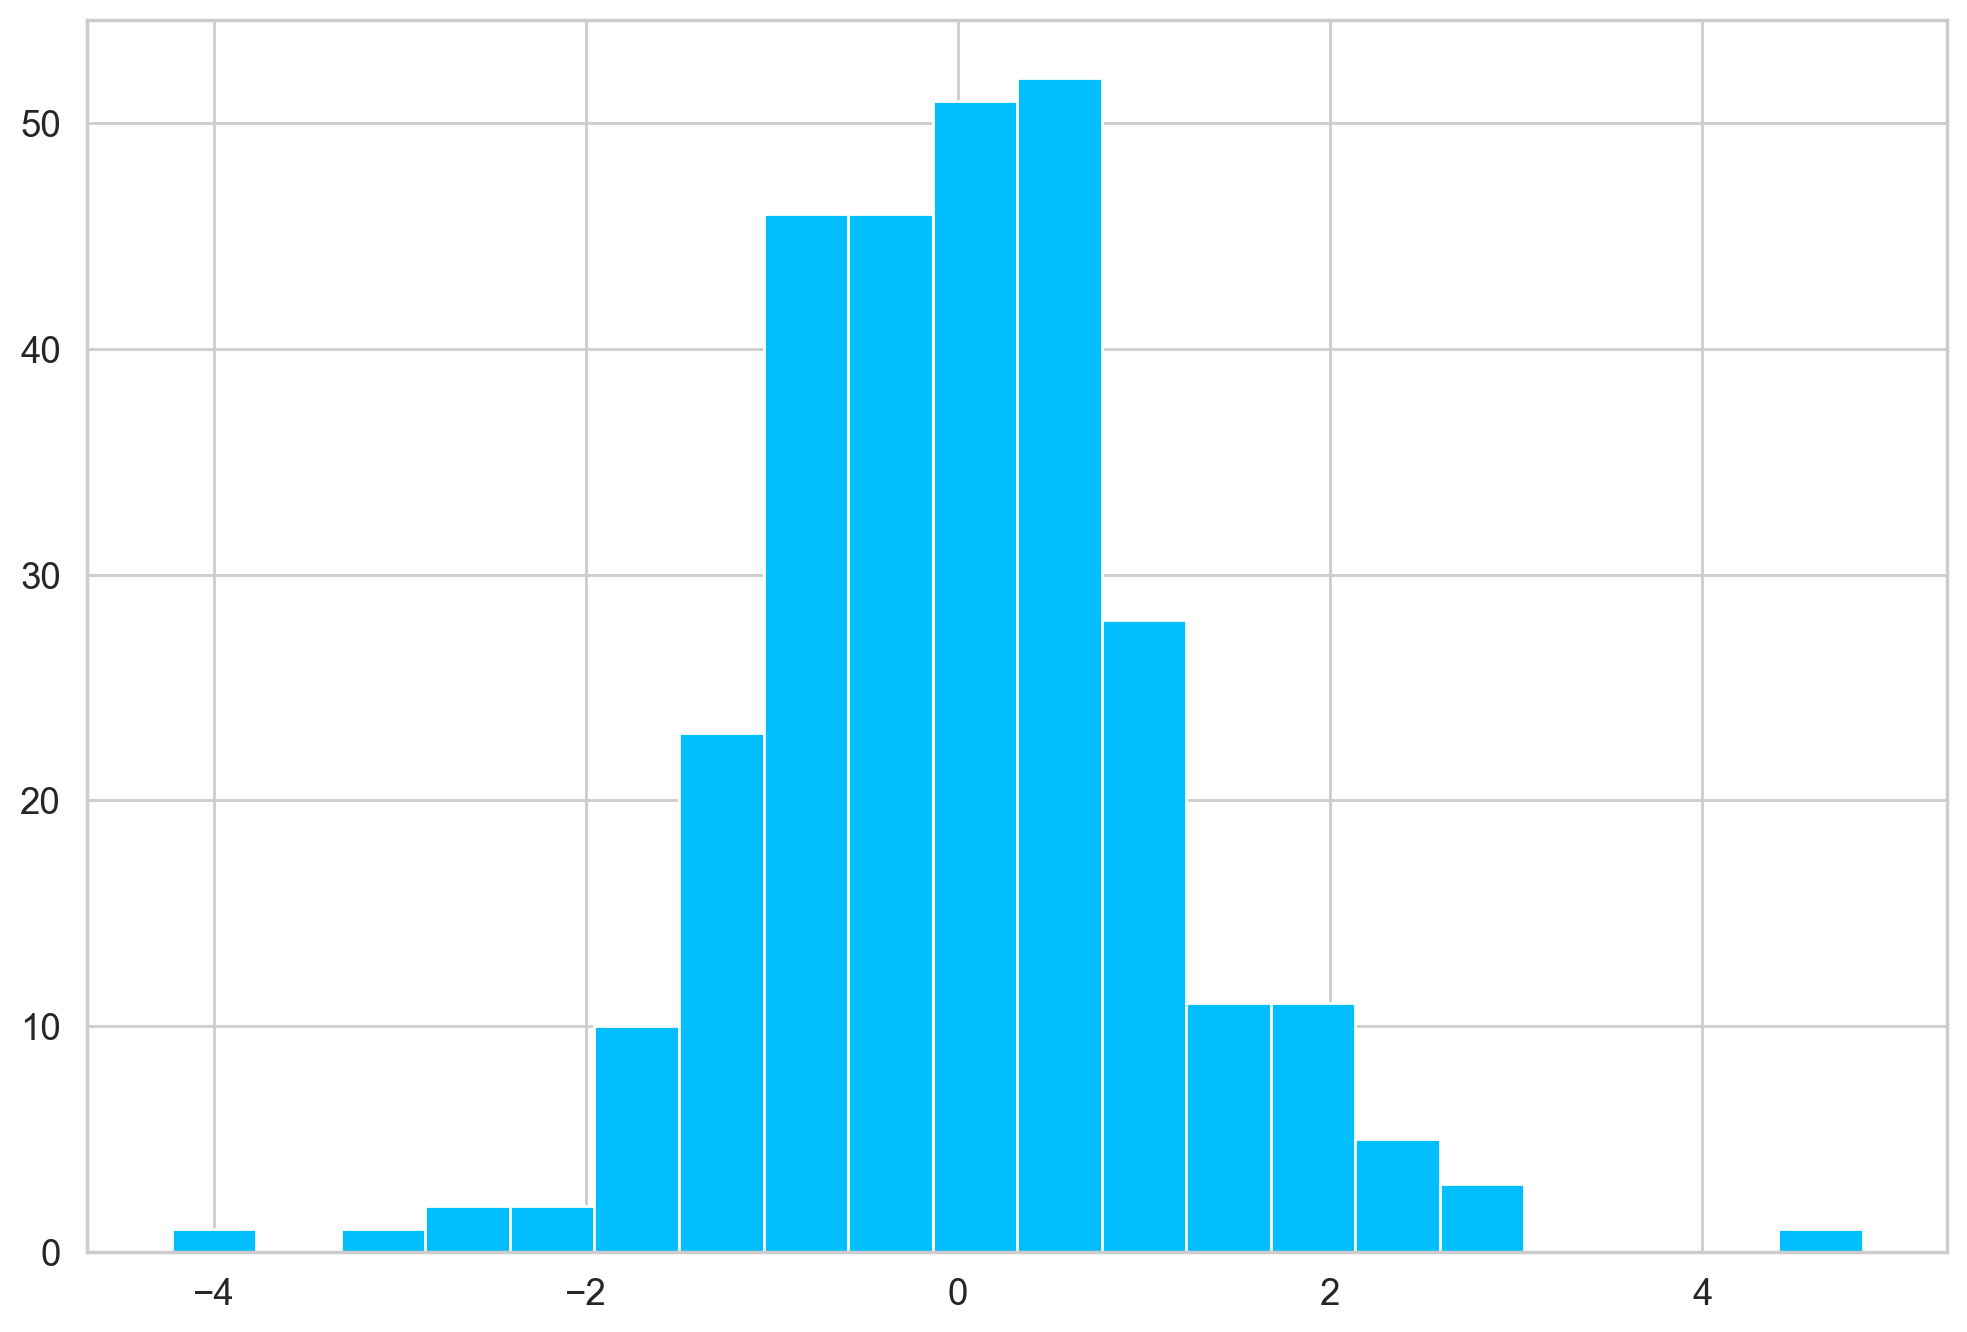

In [304]:
plt.hist(predictions-ytest, bins=20)